In [52]:
import pandas as pd
import torch
from torch_geometric.data import Data
from rdkit import Chem
import numpy as np
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
from tqdm import tqdm
import matplotlib.pyplot as plt

atoms = set([6, 7, 8, 9, 14, 15, 16, 17, 35, 53])


def get_bond_type_one_hot(bond):
    bond_type_one_hot = [0, 0, 0, 0]

    if bond.GetBondType() == Chem.rdchem.BondType.SINGLE:
        bond_type_one_hot[0] = 1
    elif bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
        bond_type_one_hot[1] = 1
    elif bond.GetBondType() == Chem.rdchem.BondType.TRIPLE:
        bond_type_one_hot[2] = 1
    elif bond.GetBondType() == Chem.rdchem.BondType.AROMATIC:
        bond_type_one_hot[3] = 1

    return bond_type_one_hot

def process_molecule(mol, node_dim=100, atomic_to_index=None, label = 'bio'):
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() not in atoms:
            return None, None, None, None
    # atomic_numbers = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    # x = torch.nn.functional.one_hot(torch.tensor(atomic_numbers) - 1, num_classes=node_dim).float()
    atomic_indices = [atomic_to_index[atom.GetAtomicNum()] for atom in mol.GetAtoms()]
    x = torch.nn.functional.one_hot(torch.tensor(atomic_indices), num_classes=11).float()

    labels_bio = -1
    name = '-1'
    # print(list(mol.GetPropNames()))
    for prop in mol.GetPropNames():
                if prop == "ReadyBiodegradability":
                    labels_bio = (int(mol.GetProp(prop)))
    if label == 'tox':
        name = mol.GetProp('_Name')
    # print(name)
    edge_index, edge_attr = [], []
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_index.append([start, end])
        bond_type = get_bond_type_one_hot(bond)
        pos_start, pos_end = mol.GetConformer().GetAtomPosition(start), mol.GetConformer().GetAtomPosition(end)
        distance = np.linalg.norm(np.array(pos_start) - np.array(pos_end))
        edge_attr.append(bond_type + [distance])

    formula = CalcMolFormula(mol)
    bio = labels_bio

    anum = []
    degs = []
    chargs = []
    hybs = []
    hs = []
    elec = []
    aro = []
    rings = []

    for atom in mol.GetAtoms():
        anum.append(torch.nn.functional.one_hot(torch.tensor(atomic_to_index[atom.GetAtomicNum()]), num_classes=11).float())
        degs.append(torch.nn.functional.one_hot(torch.tensor(atom.GetDegree()), num_classes=7))
        chargs.append(torch.tensor(atom.GetFormalCharge(), dtype=torch.int64))
        hybs.append(torch.nn.functional.one_hot(torch.tensor(atom.GetHybridization()), num_classes=8))
        hs.append(torch.nn.functional.one_hot(torch.tensor(atom.GetNumExplicitHs()), num_classes=6))

        elec.append(torch.tensor(atom.GetNumRadicalElectrons(), dtype=torch.int64))
        aro.append(torch.tensor(int(atom.GetIsAromatic())))
        rings.append(torch.tensor(int(atom.IsInRing())))


    anum = torch.stack(anum)
    degs = torch.stack(degs)
    chargs = torch.stack(chargs).unsqueeze(-1)
    hybs = torch.stack(hybs)
    hs = torch.stack(hs)
    elec = torch.stack(elec).unsqueeze(-1)
    aro = torch.stack(aro).unsqueeze(-1)
    rings = torch.stack(rings).unsqueeze(-1)
    atom_features = torch.cat([anum, degs, chargs, hybs, hs, elec, aro, rings], dim=1)

    d = Data(x=x, atom_data=atom_features, edge_index=torch.tensor(edge_index, dtype=torch.long).t().contiguous(), edge_attr=torch.tensor(edge_attr, dtype=torch.float))
    return formula, d, bio, name

def load_molecules(sdf_path, atomic_to_index = None, label = 'bio'):
    formula_list = []
    d_list = []
    bio_list = []
    name_list = []
    num_atoms_list = []
    suppl = Chem.SDMolSupplier(sdf_path)
    # i = 0
    for mol in tqdm(suppl):
        if mol is not None:
            # if i%1000 == 0:
            #     print(i)
            # i+=1
            formula, d, bio, name = process_molecule(mol, atomic_to_index= atomic_to_index, label=label)
            formula_list.append(formula)
            d_list.append(d)
            bio_list.append(bio)
            name_list.append(name)
            num_atoms_list.append(mol.GetNumAtoms())
    if label == 'bio':
        return pd.DataFrame({'formula': formula_list, 'data_object': d_list, 'node_dim':num_atoms_list, 'bio': bio_list})
    if label == 'tox':
        return pd.DataFrame({'formula': formula_list, 'data_object': d_list, 'node_dim':num_atoms_list, 'name': name_list})
    return 'error'


def load_toxicity_labels(csv_path):
    labels_df = pd.read_csv(csv_path)
    overall_toxicity = labels_df.iloc[:, 1:].sum(axis=1) > 0
    tox = [int(x) for x in overall_toxicity]
    return pd.DataFrame({'name': labels_df.iloc[:,0], 'tox': tox})

def check_num_elements(sdf_path):
    suppl = Chem.SDMolSupplier(sdf_path)

    atoms = set([6, 7, 8, 9, 14, 15, 16, 17, 35, 53])


    elements = set()

    for mol in suppl:
        if mol is not None:
            for atom in mol.GetAtoms():
                if atom.GetAtomicNum()  in atoms:
                    elements.add(atom.GetAtomicNum())

    return elements

def calc_node_dim(sdf_path):
    suppl = Chem.SDMolSupplier(sdf_path)

    max_dim = 0

    for mol in suppl:
        if mol is not None:
            max_dim = max(max_dim, mol.GetNumAtoms())

    return max_dim

def plot_atoms_distribution(sdf_path):
    suppl = Chem.SDMolSupplier(sdf_path)
    atom_counts = []

    for mol in suppl:
        if mol is not None:
            atom_counts.append(mol.GetNumAtoms())

    # Calculate percentiles
    percentiles = np.percentile(atom_counts, [90, 95, 99])

    plt.figure(figsize=(10, 6))
    plt.hist(atom_counts, bins=30, color='skyblue', edgecolor='black')
    plt.xlabel('Number of Atoms')
    plt.ylabel('Frequency')
    plt.title('Distribution of Atom Counts per Molecule')

    # Draw lines for percentiles
    for percentile, value in zip([90, 95, 99], percentiles):
        plt.axvline(x=value, color='r', linestyle='--', label=f'{percentile}th percentile: {value}')

    plt.legend()
    plt.show()

def plot_atoms_distribution_from_list(l):

    percentiles = np.percentile(l, [90, 95, 99])

    plt.figure(figsize=(10, 6))
    plt.hist(l, bins=30, color='skyblue', edgecolor='black')
    plt.xlabel('Number of Atoms')
    plt.ylabel('Frequency')
    plt.title('Distribution of Atom Counts per Molecule')

    # Draw lines for percentiles
    for percentile, value in zip([90, 95, 99], percentiles):
        plt.axvline(x=value, color='r', linestyle='--', label=f'{percentile}th percentile: {value}')

    plt.legend()
    plt.show()

def convert_to_tensors(data_object, max_atomic_index=54, node_dim=63):
    bond_type_tensor = torch.zeros((node_dim, node_dim, 4), dtype=torch.float32)
    distance_tensor = torch.zeros((node_dim, node_dim, 1), dtype=torch.float32)
    atomic_num_tensor = torch.zeros((node_dim, max_atomic_index), dtype=torch.float32)

    num_atoms = data_object.x.size(0)
    atomic_num_tensor[:num_atoms, :] = data_object.x.clone()

    edge_index = data_object.edge_index.numpy()
    edge_attr = data_object.edge_attr.numpy()

    for i, (start, end) in enumerate(edge_index.T):
        if start < node_dim and end < node_dim:
            bond_info = torch.tensor(edge_attr[i][:4], dtype=torch.float32)
            distance_info = torch.tensor(edge_attr[i][-1], dtype=torch.float32)

            bond_type_tensor[start, end, :] = bond_info
            bond_type_tensor[end, start, :] = bond_info

            distance_tensor[start, end, 0] = distance_info
            distance_tensor[end, start, 0] = distance_info

    return bond_type_tensor, distance_tensor, atomic_num_tensor
# run the above function to get the 3 tensors on every dataobject
#
# bond_type -> softmax on 3rd dim
# distance tensor -> continous on 3rd dim
# atomic tensor -> softmax on 2nd dim
# need to try adding one hot for no bond/no atom

In [53]:
tox_set = check_num_elements("../data/tox21.sdf")
bio_set = check_num_elements("../data/AllPublicnew.sdf")
combined_set = tox_set | bio_set
atomic_to_index = {num: i for i, num in enumerate(sorted(atoms))}

[12:22:33] Explicit valence for atom # 3 Cl, 2, is greater than permitted
[12:22:33] ERROR: Could not sanitize molecule ending on line 21572
[12:22:33] ERROR: Explicit valence for atom # 3 Cl, 2, is greater than permitted
[12:22:34] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 1 ignored.
[12:22:34] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 1 ignored.
[12:22:34] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 6 ignored.
[12:22:34] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 6 ignored.
[12:22:35] Explicit valence for atom # 2 Si, 8, is greater than permitted
[12:22:35] ERROR: Could not sanitize molecule ending on line 346021
[12:22:35] ERROR: Explicit valence for atom # 2 Si, 8, is greater than permitted
[12:22:35] Explicit valence for atom # 3 Cl, 2, is greater than permitted
[12:22:35] ERROR: Could not sanitize molecule ending on l

In [54]:
print(atomic_to_index)

{6: 0, 7: 1, 8: 2, 9: 3, 14: 4, 15: 5, 16: 6, 17: 7, 35: 8, 53: 9}


In [3]:
len(combined_set)

54

[12:22:51] Explicit valence for atom # 3 Cl, 2, is greater than permitted
[12:22:51] ERROR: Could not sanitize molecule ending on line 21572
[12:22:51] ERROR: Explicit valence for atom # 3 Cl, 2, is greater than permitted
[12:22:52] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 1 ignored.
[12:22:52] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 1 ignored.
[12:22:52] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 6 ignored.
[12:22:52] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 6 ignored.
[12:22:53] Explicit valence for atom # 2 Si, 8, is greater than permitted
[12:22:53] ERROR: Could not sanitize molecule ending on line 346021
[12:22:53] ERROR: Explicit valence for atom # 2 Si, 8, is greater than permitted
[12:22:53] Explicit valence for atom # 3 Cl, 2, is greater than permitted
[12:22:53] ERROR: Could not sanitize molecule ending on l

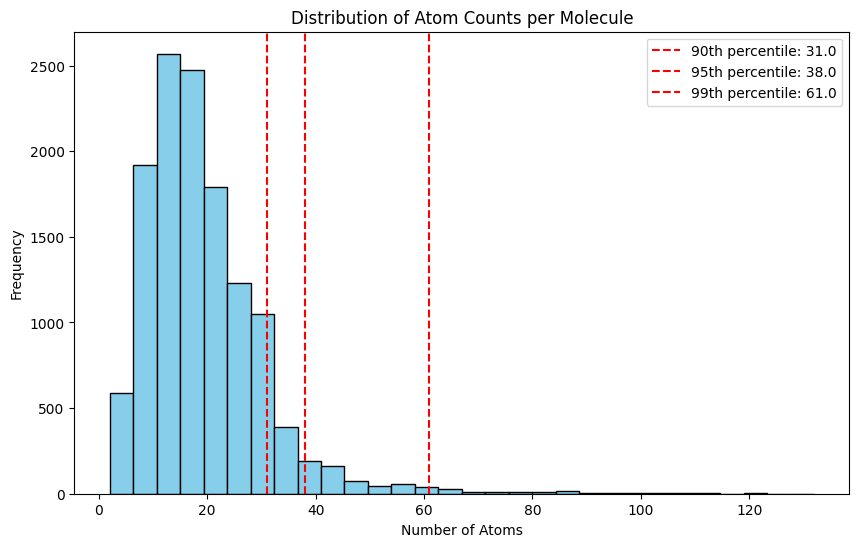

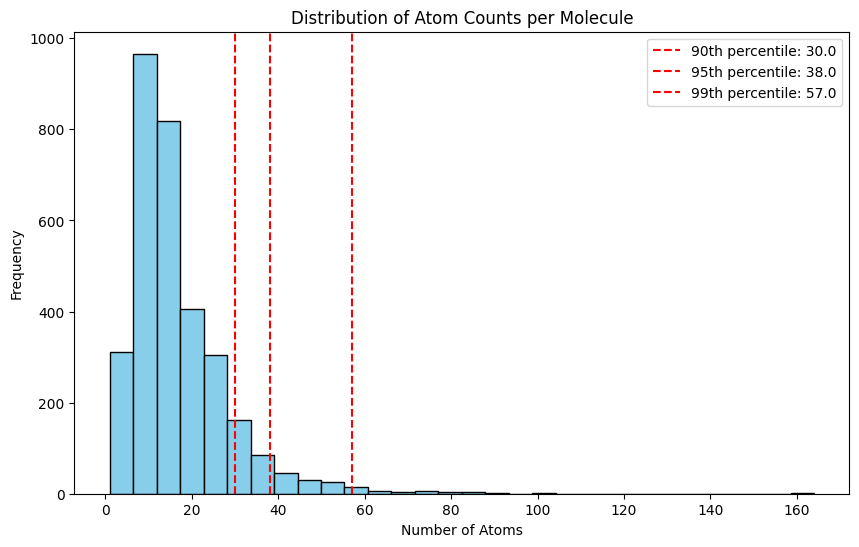

In [55]:
# tox_node_dim = calc_node_dim("tox21/tox21.sdf")
# bio_node_dim = calc_node_dim("AllPublicnew.sdf")
# node_dim = max(tox_node_dim, bio_node_dim)
plot_atoms_distribution("../data/tox21.sdf")
plot_atoms_distribution("../data/AllPublicnew.sdf")

In [56]:
tox_data_list = load_molecules('../data/tox21.sdf', atomic_to_index = atomic_to_index, label='tox')

  2%|▏         | 280/12707 [00:32<25:13,  8.21it/s][12:23:36] Explicit valence for atom # 3 Cl, 2, is greater than permitted
[12:23:36] ERROR: Could not sanitize molecule ending on line 21572
[12:23:36] ERROR: Explicit valence for atom # 3 Cl, 2, is greater than permitted
 22%|██▏       | 2777/12707 [04:34<14:55, 11.09it/s][12:27:38] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 1 ignored.
[12:27:38] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 1 ignored.
[12:27:38] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 6 ignored.
[12:27:38] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 6 ignored.
 35%|███▍      | 4428/12707 [07:33<12:18, 11.21it/s][12:30:37] Explicit valence for atom # 2 Si, 8, is greater than permitted
[12:30:37] ERROR: Could not sanitize molecule ending on line 346021
[12:30:37] ERROR: Explicit valence for atom # 2 Si, 8, is

In [57]:
bio_data_list = load_molecules('../data/AllPublicnew.sdf', atomic_to_index = atomic_to_index, label='bio')

100%|██████████| 3192/3192 [03:40<00:00, 14.47it/s]


In [263]:
bio_data_list

,formula,data_object,node_dim,bio
0,C8H7Br,"[(x, [tensor([0., 0., 0., 0., 0., 0., 0., 0., ...",9,0
1,C2H2Br2,"[(x, [tensor([0., 0., 0., 0., 0., 0., 0., 0., ...",4,0
2,C8H7Br,"[(x, [tensor([0., 0., 0., 0., 0., 0., 0., 0., ...",9,0
3,CHBr3,"[(x, [tensor([0., 0., 0., 0., 0., 0., 0., 0., ...",4,0
4,C2H2Br4,"[(x, [tensor([0., 0., 0., 0., 0., 0., 0., 0., ...",6,0
...,...,...,...,...
3187,C12H10O,"[(x, [tensor([0., 0., 0., 0., 1., 0., 0., 0., ...",13,0
3188,C18H15Bi,"[(x, [tensor([0., 0., 0., 0., 1., 0., 0., 0., ...",19,0
3189,C24H20Sn,"[(x, [tensor([0., 0., 0., 0., 1., 0., 0., 0., ...",25,0
3190,C18H15Sn,"[(x, [tensor([0., 0., 0., 0., 1., 0., 0., 0., ...",19,0


In [58]:
bio_df = bio_data_list.sort_values(by='bio', ascending=False)
bio_df = bio_df.drop_duplicates(subset='formula', keep='first')
bio_df.reset_index(inplace=True)

In [59]:
train_labels_tox = load_toxicity_labels('../data/tox21_labels_train.csv')
test_labels_tox = load_toxicity_labels('../data/tox21_labels_test.csv')
combined_labels_tox = pd.concat([train_labels_tox, test_labels_tox])

In [60]:
tox_df = tox_data_list.merge(combined_labels_tox, on='name')
tox_df = tox_df.sort_values(by='tox', ascending=False)
tox_df = tox_df.drop_duplicates(subset='formula', keep='first')
tox_df.reset_index(inplace=True)

In [61]:
combined_df = tox_df.merge(bio_df, on='formula', how='outer')
combined_df['data_object'] = np.where(combined_df['data_object_x'].notna(), combined_df['data_object_x'], combined_df['data_object_y'])
combined_df = combined_df.drop(columns=['data_object_x', 'data_object_y'])
combined_df['node_dim'] = np.where(combined_df['node_dim_x'].notna(), combined_df['node_dim_x'], combined_df['node_dim_y'])
combined_df = combined_df.drop(columns=['node_dim_x', 'node_dim_y'])
combined_df = combined_df[(combined_df['tox'] == 0) | (combined_df['bio'] == 1)]

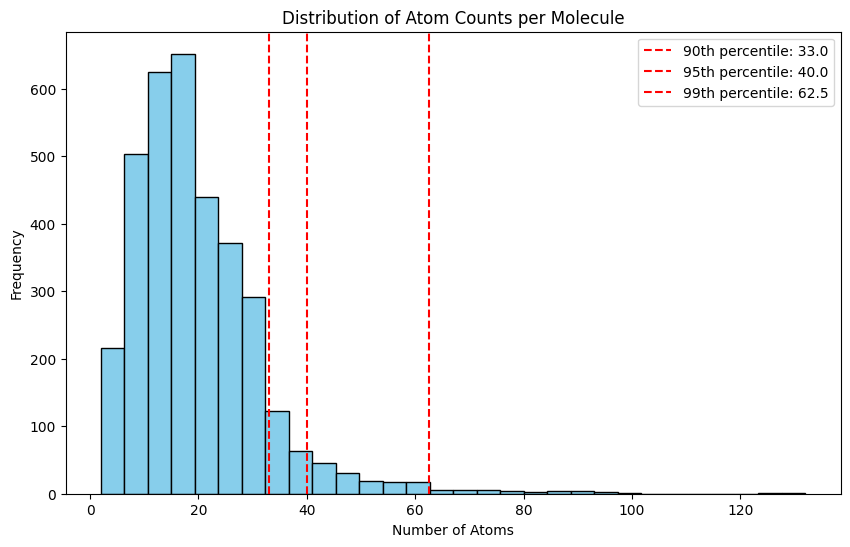

In [62]:
plot_atoms_distribution_from_list(list(combined_df['node_dim']))

In [63]:
combined_df = combined_df[combined_df['node_dim'] <= 63]

In [13]:
tox_df

,index,formula,data_object,node_dim,name,tox
0,11758,C15H26O6S3,"[(x, [tensor([0., 0., 0., 0., 1., 0., 0., 0., ...",24,NCGC00256198-01,1
1,4000,C15H13N3O2S,"[(x, [tensor([0., 0., 0., 0., 1., 0., 0., 0., ...",21,NCGC00160657-01,1
2,4011,C28H32N2O10,"[(x, [tensor([0., 0., 0., 0., 0., 0., 1., 0., ...",40,NCGC00095120-01,1
3,9344,C6H6BrN,"[(x, [tensor([0., 0., 0., 0., 0., 1., 0., 0., ...",8,NCGC00256346-01,1
4,4008,C61H90N18O25S3,"[(x, [tensor([0., 0., 0., 0., 0., 0., 1., 0., ...",107,NCGC00182036-01,1
...,...,...,...,...,...,...
5847,5088,C16H33NO3,"[(x, [tensor([0., 0., 0., 0., 0., 0., 1., 0., ...",20,NCGC00181001-01,0
5848,5089,C11H16N2O8,"[(x, [tensor([0., 0., 0., 0., 1., 0., 0., 0., ...",21,NCGC00016651-03,0
5849,5109,C17H26N4O3S2,"[(x, [tensor([0., 0., 0., 0., 0., 1., 0., 0., ...",26,NCGC00188432-01,0
5850,5049,C12H9ClO2S,"[(x, [tensor([0., 0., 0., 0., 1., 0., 0., 0., ...",16,NCGC00255932-01,0


In [14]:
combined_df

,index_x,formula,name,tox,index_y,bio,data_object,node_dim
40,4017.0,C21H26O2,NCGC00164611-01,1.0,2156.0,1.0,"[(x, [tensor([0., 0., 0., 0., 1., 0., 0., 0., ...",23.0
41,4016.0,C19H28O2,NCGC00093802-04,1.0,826.0,1.0,"[(x, [tensor([0., 0., 0., 0., 1., 0., 0., 0., ...",21.0
47,3959.0,C19H26O2,NCGC00023902-06,1.0,813.0,1.0,"[(x, [tensor([0., 0., 0., 0., 1., 0., 0., 0., ...",21.0
67,3966.0,C21H30O5,NCGC00022848-06,1.0,812.0,1.0,"[(x, [tensor([0., 0., 0., 0., 1., 0., 0., 0., ...",26.0
73,3978.0,C26H42O4,NCGC00183596-01,1.0,584.0,1.0,"[(x, [tensor([0., 0., 0., 0., 1., 0., 0., 0., ...",30.0
...,...,...,...,...,...,...,...,...
6084,NaN,C25H40N2O9,NaN,NaN,2790.0,1.0,"[(x, [tensor([0., 0., 0., 0., 0., 0., 1., 0., ...",36.0
6085,NaN,C4H8OS2,NaN,NaN,626.0,1.0,"[(x, [tensor([0., 0., 0., 0., 1., 0., 0., 0., ...",7.0
6086,NaN,C9H13NO8,NaN,NaN,2783.0,1.0,"[(x, [tensor([0., 0., 0., 0., 0., 0., 1., 0., ...",18.0
6087,NaN,CH2O2,NaN,NaN,2876.0,1.0,"[(x, [tensor([0., 0., 0., 0., 0., 0., 1., 0., ...",3.0


In [64]:
tox_df.to_csv('../data/tox_data.csv', index=False)
bio_df.to_csv('../data/bio_data.csv', index=False)
combined_df.to_csv('../data/combined_data.csv', index=False)

In [19]:
combined_df.iloc[0].data_object

40      [(x, [tensor([0., 0., 0., 0., 1., 0., 0., 0., ...
41      [(x, [tensor([0., 0., 0., 0., 1., 0., 0., 0., ...
47      [(x, [tensor([0., 0., 0., 0., 1., 0., 0., 0., ...
67      [(x, [tensor([0., 0., 0., 0., 1., 0., 0., 0., ...
73      [(x, [tensor([0., 0., 0., 0., 1., 0., 0., 0., ...
                              ...                        
6084    [(x, [tensor([0., 0., 0., 0., 0., 0., 1., 0., ...
6085    [(x, [tensor([0., 0., 0., 0., 1., 0., 0., 0., ...
6086    [(x, [tensor([0., 0., 0., 0., 0., 0., 1., 0., ...
6087    [(x, [tensor([0., 0., 0., 0., 0., 0., 1., 0., ...
6088    [(x, [tensor([0., 0., 0., 0., 0., 0., 1., 0., ...
Name: data_object, Length: 3738, dtype: object

In [25]:
bond_matrix, distance_matrix, atomic_number_matrix = convert_to_tensors(combined_df.iloc[0].data_object)